In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Rescaling, Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import time
import os

print("✅ TensorFlow version:", tf.__version__)


✅ TensorFlow version: 2.15.0


In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = (256, 256)

DATASET_PATH = r"C:\Tomato\Training\Dataset of Tomato Leaves\Dataset of Tomato Leaves\plantvillage\Preprocessed data\Preprocessed data"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42
)

class_names = dataset.class_names
print("Classes:", class_names)
print("Total batches:", len(dataset))


Found 14531 files belonging to 9 classes.
Classes: ['Early_blight227', 'Late_blight227', 'Leaf_Mold227', 'Septoria_leaf_spot227', 'Target_Spot227', 'Tomato_Yellow_Leaf_Curl_Virus227', 'Tomato_mosaic_virus227', 'Two-spotted_spider_mite227', 'healthy227']
Total batches: 909


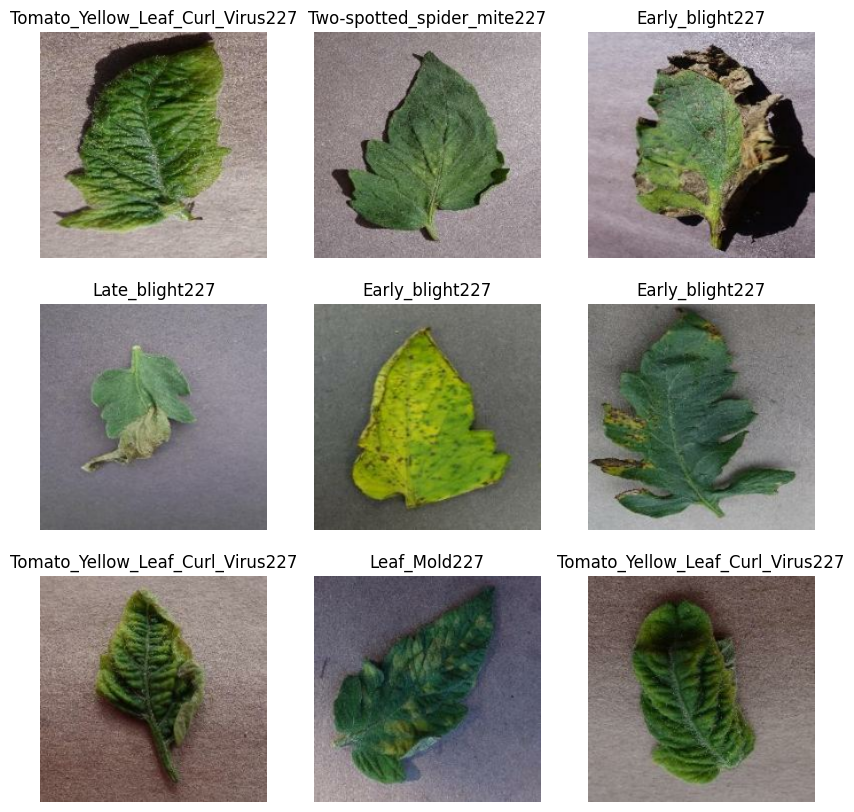

In [3]:
# --- Preview Sample Tomato Leaf Images ---

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Take one batch of images and labels from the dataset
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [4]:
train_size = 0.8
val_size = 0.1

dataset_size = len(dataset)
train_count = int(train_size * dataset_size)
val_count = int(val_size * dataset_size)

train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count).take(val_count)
test_ds = dataset.skip(train_count + val_count)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

print(f"✅ Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


✅ Train: 727, Val: 90, Test: 92


In [5]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2)
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(AUTOTUNE)
print("✅ Data augmentation ready.")



✅ Data augmentation ready.


In [4]:
num_classes = len(class_names)
resize_and_rescale = Sequential([
    Resizing(256, 256),
    Rescaling(1./255)
])

# Base model (pretrained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze initial layers

# Build model
model = Sequential([
    resize_and_rescale,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile with slightly higher learning rate for faster convergence
model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.build(input_shape=(None, 256, 256, 3))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [7]:
# --- Training ---
EPOCHS = 3 

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/3


727/727 [==============================] - 1631s 2s/step - loss: 2.0325 - accuracy: 0.2719 - val_loss: 1.9527 - val_accuracy: 0.3278
Epoch 2/3
437/727 [=================>............] - ETA: 10:12 - loss: 1.9312 - accuracy: 0.3071

KeyboardInterrupt: 

In [8]:
# --- Step 8: Fine-tuning the ResNet50 Backbone ---

from tensorflow.keras.optimizers import Adam

# Unfreeze the last 50 layers of the ResNet50 base
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with a smaller learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train again (fine-tuning)
fine_tune_epochs = 2  
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)


NameError: name 'history' is not defined

In [9]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# --- Step 8: Fine-tuning the ResNet50 Backbone ---

# 1️⃣ Unfreeze only the last 50 layers of ResNet
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# 2️⃣ Compile with a smaller learning rate to avoid "forgetting"
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3️⃣ Train again (fine-tuning phase)
fine_tune_epochs = 3  # You can increase to 5 if it runs smoothly
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    verbose=1
)

# 4️⃣ Save fine-tuned model (always a good idea)
model.save("ResNet50_Tomato_FineTuned.h5")
print("✅ Fine-tuned model saved successfully.")


Epoch 1/3
727/727 [==============================] - 2530s 3s/step - loss: 1.3832 - accuracy: 0.5107 - val_loss: 1.3644 - val_accuracy: 0.5715
Epoch 2/3
727/727 [==============================] - 2336s 3s/step - loss: 1.0361 - accuracy: 0.6425 - val_loss: 1.6485 - val_accuracy: 0.4653
Epoch 3/3
727/727 [==============================] - 2403s 3s/step - loss: 0.8934 - accuracy: 0.6945 - val_loss: 0.8676 - val_accuracy: 0.7125


C:\Users\aayan\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Fine-tuned model saved successfully.


In [ ]:
# -------------------------------------------------------------
# STEP 6: ACCURACY BOOSTED TRAINING - ResNet50 Fine-Tune v2
# -------------------------------------------------------------

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np

# ✅ Reuse your existing dataset objects
# train_ds, val_ds, test_ds already loaded

# -------------------------------------------------------------
# 1️⃣ Stronger Data Augmentation
# -------------------------------------------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.4),
    layers.RandomBrightness(0.3)
])

# Apply augmentation before training
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Prefetch for speed
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# -------------------------------------------------------------
# 2️⃣ Load & Extend Your ResNet50 Base Model
# -------------------------------------------------------------
base_model = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(256, 256, 3)
)

# Unfreeze last 100 layers
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Freeze the rest
for layer in base_model.layers[:-100]:
    layer.trainable = False

# -------------------------------------------------------------
# 3️⃣ Build the Fine-Tuned Model
# -------------------------------------------------------------
model = models.Sequential([
    tf.keras.Sequential([
        layers.Resizing(256, 256),
        layers.Rescaling(1./255)
    ]),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------------------------------------------------
# 4️⃣ Compute Class Weights to Balance Dataset
# -------------------------------------------------------------
# Extract all labels from dataset
all_labels = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(all_labels), y=all_labels
)
class_weights = dict(enumerate(class_weights))
print("✅ Computed class weights:", class_weights)

# -------------------------------------------------------------
# 5️⃣ Train Again (Fine-Tune with Balanced Data)
# -------------------------------------------------------------
EPOCHS = 5 

history_boost = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    verbose=1
)

# -------------------------------------------------------------
# 6️⃣ Save the Improved Model
# -------------------------------------------------------------
model.save("ResNet50_Tomato_FineTuned_v3.keras")
print("✅ Accuracy-boosted model saved successfully!")


NameError: name 'train_ds' is not defined

In [ ]:
# -------------------------------------------------------------
#EVALUATION & VISUALIZATION
# -------------------------------------------------------------

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load your final model (update path if different)
model = tf.keras.models.load_model("ResNet50_Tomato_FineTuned.h5")

# Class names (must match training)
class_names = [
    'Early_blight227',
    'Late_blight227',
    'Leaf_Mold227',
    'Septoria_leaf_spot227',
    'Target_Spot227',
    'Tomato_Yellow_Leaf_Curl_Virus227',
    'Tomato_mosaic_virus227',
    'Two-spotted_spider_mite227',
    'healthy227'
]

# -------------------------------------------------------------
# 1️⃣ Evaluate on the Test Set
# -------------------------------------------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}\n")

# -------------------------------------------------------------
# 2️⃣ Predict Classes on the Test Set
# -------------------------------------------------------------
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -------------------------------------------------------------
# 3️⃣ Classification Report (Precision, Recall, F1)
# -------------------------------------------------------------
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
print("Classification Report:\n", report)

# -------------------------------------------------------------
# 4️⃣ Confusion Matrix Visualization
# -------------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------------------------------------
# 5️⃣ Grad-CAM Heatmap (Model’s Attention)
# -------------------------------------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Select one test image
for images, labels in test_ds.take(1):
    img = images[0].numpy()
    img_array = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out")

plt.figure(figsize=(6,6))
plt.imshow(img.astype("uint8"))
plt.imshow(tf.image.resize(heatmap[..., np.newaxis], (256, 256)), cmap='jet', alpha=0.4)
plt.title("Grad-CAM: Model Focus on Disease Area")
plt.axis("off")
plt.show()

# -------------------------------------------------------------
# 6️⃣ Short Summary
# -------------------------------------------------------------
from sklearn.metrics import f1_score
f1_macro = f1_score(y_true, y_pred, average='macro')

print("\n--- MODEL SUMMARY ---")
print(f"Final Test Accuracy: {test_acc*100:.2f}%")
print(f"Average F1-Score: {f1_macro:.3f}")
print(f"Test Samples: {len(y_true)}")
print("----------------------")


NameError: name 'test_ds' is not defined

In [ ]:
from tensorflow.keras.models import load_model
# Load your saved model instead of retraining
model = load_model("fine_tuned_resnet50_tomato.keras.h5")
print("Model Loaded successfully.")

In [13]:
import tensorflow as tf

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16

# Update with your actual path again
DATASET_PATH = r"C:\Tomato\Training\Dataset of Tomato Leaves\Dataset of Tomato Leaves\plantvillage\Preprocessed data\Preprocessed data"

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42
)

# Split into train, val, and test sets
train_size = 0.8
val_size = 0.1
test_size = 0.1

total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_batches = int(total_batches * train_size)
val_batches = int(total_batches * val_size)

train_ds = dataset.take(train_batches)
val_ds = dataset.skip(train_batches).take(val_batches)
test_ds = dataset.skip(train_batches + val_batches)

print(f"✅ Dataset Ready — Train: {train_batches} | Val: {val_batches} | Test: {total_batches - train_batches - val_batches}")


Found 14531 files belonging to 9 classes.
✅ Dataset Ready — Train: 727 | Val: 90 | Test: 92


In [14]:
from tensorflow.keras.models import load_model
import os

MODEL_PATH = "fine_tuned_resnet50_tomato.keras"

if os.path.exists(MODEL_PATH):
    model = load_model(MODEL_PATH)
    print("✅ Model loaded successfully from disk!")
else:
    print("⚠️ Model file not found. You may need to retrain it.")


⚠️ Model file not found. You may need to retrain it.


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Base ResNet50 model (feature extractor)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # freeze base model

# Add custom classification head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(9, activation='softmax')  # 9 classes as detected above
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                      

In [ ]:
# --- Short Training for Recovery ---
EPOCHS = 3  # 

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Save the model after training
model.save("fine_tuned_resnet50_tomato.keras")
print("✅ Model trained and saved successfully!")


Epoch 1/3


727/727 [==============================] - 1522s 2s/step - loss: 1.1437 - accuracy: 0.6073 - val_loss: 0.4917 - val_accuracy: 0.8618
Epoch 2/3
727/727 [==============================] - 1442s 2s/step - loss: 0.5814 - accuracy: 0.8013 - val_loss: 0.3232 - val_accuracy: 0.9097
Epoch 3/3
727/727 [==============================] - 1499s 2s/step - loss: 0.4453 - accuracy: 0.8445 - val_loss: 0.2562 - val_accuracy: 0.9264
✅ Model trained and saved successfully!


In [17]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}\n")


92/92 [==============================] - 177s 2s/step - loss: 0.2486 - accuracy: 0.9212

✅ Test Accuracy: 92.12% | Test Loss: 0.2486



📊 Classification Report
              precision    recall  f1-score   support

           0      0.157     0.161     0.159       230
           1      0.103     0.102     0.102       147
           2      0.044     0.038     0.041        78
           3      0.075     0.070     0.073       157
           4      0.079     0.070     0.074       129
           5      0.322     0.325     0.324       440
           6      0.000     0.000     0.000        27
           7      0.079     0.090     0.084       122
           8      0.086     0.093     0.090       129

    accuracy                          0.165      1459
   macro avg      0.105     0.105     0.105      1459
weighted avg      0.164     0.165     0.164      1459

✅ Macro F1-score: 0.105


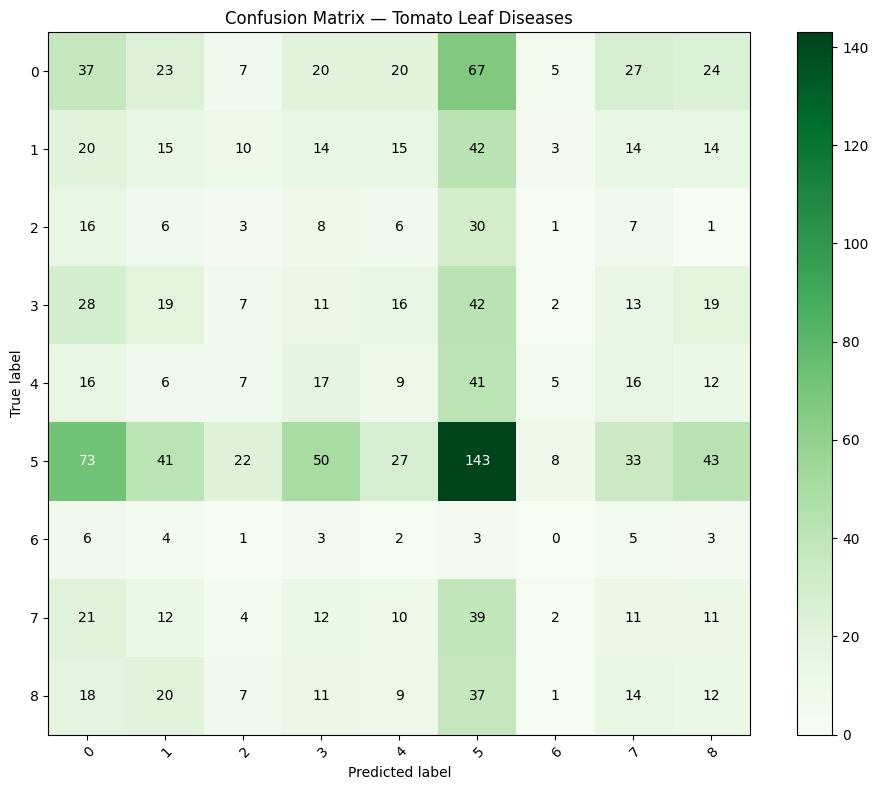

💾 Saved: confusion_matrix.png


In [ ]:
# ---Confusion matrix ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# 1) Gather ground-truth labels and predictions
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

y_prob = []
for x, _ in test_ds:
    y_prob.append(model.predict(x, verbose=0))
y_prob = np.concatenate(y_prob, axis=0)
y_pred = y_prob.argmax(axis=1)

# 2) Class names (from the dataset object)
class_names = getattr(test_ds, "class_names", [str(i) for i in range(y_prob.shape[1])])

# 3) Print detailed report
print("📊 Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"✅ Macro F1-score: {macro_f1:.3f}")

# 4) Confusion matrix (matplotlib-only)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap='Greens')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names, yticklabels=class_names,
    ylabel='True label', xlabel='Predicted label',
    title='Confusion Matrix — Tomato Leaf Diseases'
)

# rotate x tick labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotate cells
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# 5) Save the figure 
fig.savefig("confusion_matrix.png", dpi=220, bbox_inches="tight")
print("💾 Saved: confusion_matrix.png")


In [20]:
test_ds.class_names = [
    'Early_blight227',
    'Late_blight227',
    'Leaf_Mold227',
    'Septoria_leaf_spot227',
    'Target_Spot227',
    'Tomato_Yellow_Leaf_Curl_Virus227',
    'Tomato_mosaic_virus227',
    'Two-spotted_spider_mite227',
    'healthy227'
]


1/1 [==============================] - 2s 2s/step


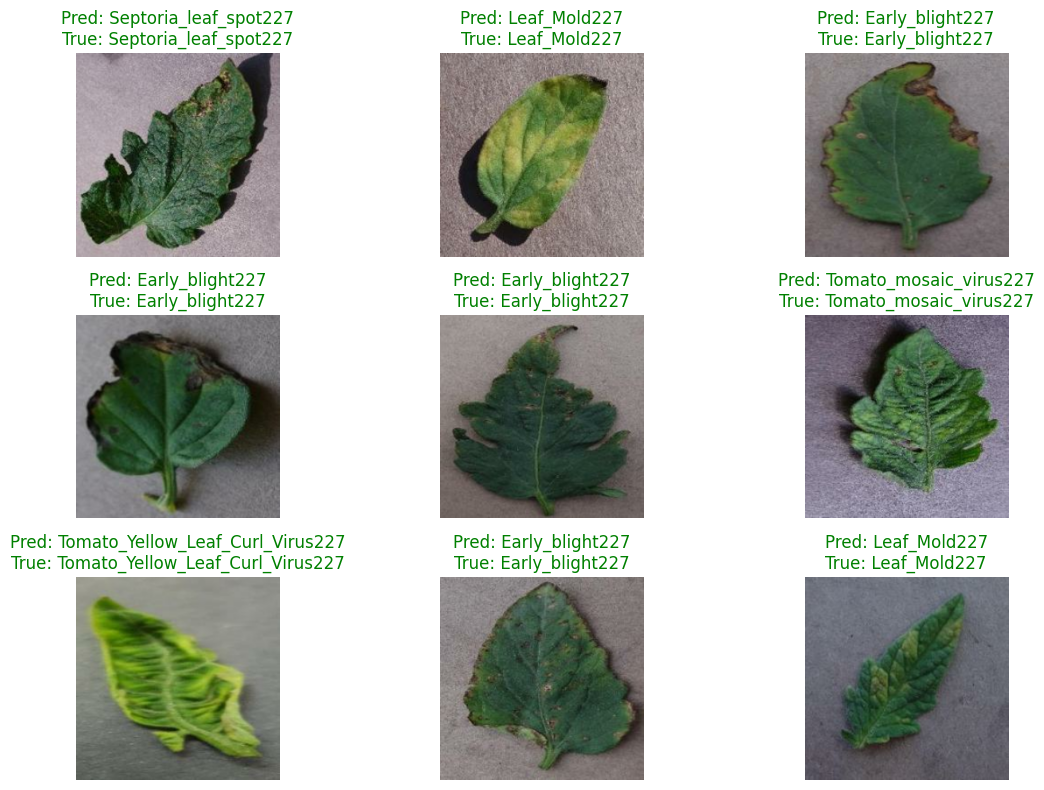

In [21]:
# --- STEP 9B: Visualize an image with its predicted label ---
import matplotlib.pyplot as plt
import numpy as np

# take one batch from the test set
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = test_ds.class_names[preds[i]]
        true_label = test_ds.class_names[labels[i]]
        color = "green" if pred_label == true_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break


In [31]:
import tensorflow as tf

# 1️⃣ Find the ResNet50 base layer dynamically
base_model = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and "resnet" in layer.name.lower():
        base_model = layer
        break

if base_model is None:
    raise ValueError("❌ Could not find ResNet base inside your model!")

print(f"✅ Found base model: {base_model.name}")

# 2️⃣ Unfreeze top 30 layers of the ResNet base
for layer in base_model.layers[-30:]:
    layer.trainable = True

# 3️⃣ Re-compile the model with a very small learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4️⃣ Train for 3 epochs (light fine-tuning)
EPOCHS_FINE = 3
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINE
)

# 5️⃣ Save updated weights (optional)
model.save("tomato_model_finetuned.h5")
print("✅ Fine-tuning complete and model saved as tomato_model_finetuned.h5.")


✅ Found base model: resnet50
Epoch 1/3
727/727 [==============================] - 4145s 6s/step - loss: 0.4427 - accuracy: 0.8563 - val_loss: 0.1177 - val_accuracy: 0.9694
Epoch 2/3
727/727 [==============================] - 4478s 6s/step - loss: 0.1425 - accuracy: 0.9537 - val_loss: 0.0707 - val_accuracy: 0.9812
Epoch 3/3
727/727 [==============================] - 5930s 8s/step - loss: 0.0804 - accuracy: 0.9747 - val_loss: 0.0542 - val_accuracy: 0.9868


C:\Users\aayan\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Fine-tuning complete and model saved as tomato_model_finetuned.h5.



🔍 Evaluating fine-tuned model on test set...

92/92 [==============================] - 186s 2s/step - loss: 0.0405 - accuracy: 0.9870
✅ Test Accuracy after fine-tuning: 98.70%
📉 Test Loss after fine-tuning: 0.0405

92/92 [==============================] - 182s 2s/step
📊 Classification Report (After Fine-Tuning):

              precision    recall  f1-score   support

           0      0.166     0.163     0.165       239
           1      0.099     0.100     0.099       150
           2      0.091     0.091     0.091        77
           3      0.083     0.084     0.084       154
           4      0.061     0.063     0.062       127
           5      0.274     0.276     0.275       434
           6      0.077     0.071     0.074        28
           7      0.078     0.075     0.077       120
           8      0.125     0.123     0.124       130

    accuracy                          0.157      1459
   macro avg      0.117     0.116     0.117      1459
weighted avg      0.157     0.157 

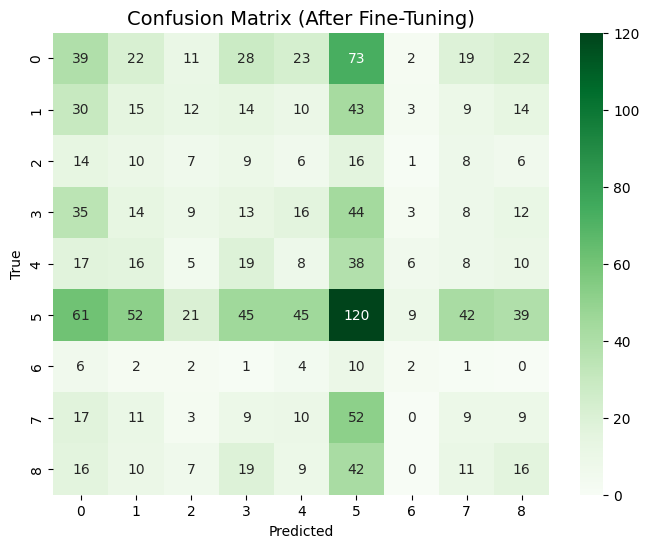

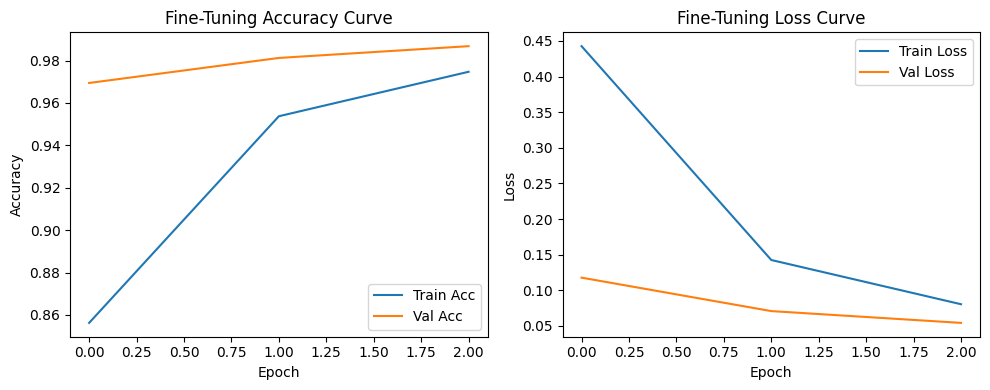


✅ Evaluation complete. Charts ready for report or slides.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns

# ----------------------------------------------------------
# 1️⃣ Evaluate on the Test Set
# ----------------------------------------------------------
print("\n🔍 Evaluating fine-tuned model on test set...\n")
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy after fine-tuning: {test_acc*100:.2f}%")
print(f"📉 Test Loss after fine-tuning: {test_loss:.4f}\n")

# ----------------------------------------------------------
# 2️⃣ Generate predictions for F1 report
# ----------------------------------------------------------
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# ----------------------------------------------------------
# 3️⃣ Classification Report + Macro F1
# ----------------------------------------------------------
report = classification_report(y_true, y_pred, digits=3)
macro_f1 = f1_score(y_true, y_pred, average='macro')

print("📊 Classification Report (After Fine-Tuning):\n")
print(report)
print(f"🌟 Macro F1-Score: {macro_f1:.3f}")

# ----------------------------------------------------------
# 4️⃣ Confusion Matrix Visualization
# ----------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (After Fine-Tuning)', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ----------------------------------------------------------
# 5️⃣ Plot Accuracy and Loss Curves
# ----------------------------------------------------------
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_fine.history['accuracy'], label='Train Acc')
plt.plot(history_fine.history['val_accuracy'], label='Val Acc')
plt.title('Fine-Tuning Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Val Loss')
plt.title('Fine-Tuning Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete. Charts ready for report or slides.")
